# 2 - End to end machine learning project

In this chapter, we will work through an end-to-end machine
learning project to get the feel for the field. We will work
with real-estate data, pretending to work for a real-estate 
company.

In [1]:
import pandas as pd
import numpy as np

## Look at the Big Picture

Our first task will be to create a model to find the median
house price for each district in the data.

### Framing the problem

First, we need to understand what is the objective of building
this model. We ask our boss, and he answers that this model
will be used to decide whether or not it is worth it to invest
in a given area. Moreover, our model results will be fed to 
another ML system to make this decision, so it is important
our results are as accurate as possible.

The next question is **what are the current solutions** to this
objective. This will help us find a metric for our performance,
as well as put our solution in perspective. Our boss answers
that currently there is a team of experts that do this estimation,
and that sometimes their estimates are off by up to 30%.

Let's begin designing our system by answering some questions.
The most basic one - what type of system is ours? Supervised,
for a regression task, I believe. As for batch or online learning,
batch will suffice, as housing sells are usually a slow process,
and accuracy is key in this context.

The authors says this is, more specifically a **multiple regression**
problem, and an **univariate** one, because we are using multiple 
features to predict a single variable.

### Select a Performance Measure

A typical regression measure for regression problems is the 
root mean squared error (RMSE), in which for each instance, we
calculate the error, square this value, sum all square errors
and take the mean, and than root this value. This is more sensible
to high errors.

### Check the Assumptions

It is important to check if what we're assuming is actually right
about this system. For example, maybe the team that will use our
output data won't use the numeric data, but will categorize it 
in 'Cheap', 'Expensive', 'Medium', etc. In that case, our task 
would not be a regression task, but a classification one! We're 
better finding this out now, instead of months down the line.

In this case, after talking to the downstream team, they reassure
us that they'll need the numeric data.

## Get the Data

Time to get our hands dirty!

### Download the Data

We'll do that by code:

In [2]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

from sklearn import preprocessing

def load_housing_data():
  tarball_path = Path('datasets/housing.tgz')
  if not tarball_path.is_file():
    Path('datasets').mkdir(parents=True, exist_ok=True)
    url = "https://github.com/ageron/data/raw/main/housing.tgz"
    urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
      housing_tarball.extractall(path='datasets', filter='data')
  return pd.read_csv('datasets/housing/housing.csv')

housing_full = load_housing_data()

In [3]:
housing_full.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing_full.info()

<class 'pandas.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  str    
dtypes: float64(9), str(1)
memory usage: 1.7 MB


In [5]:
housing_full['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [6]:
housing_full.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

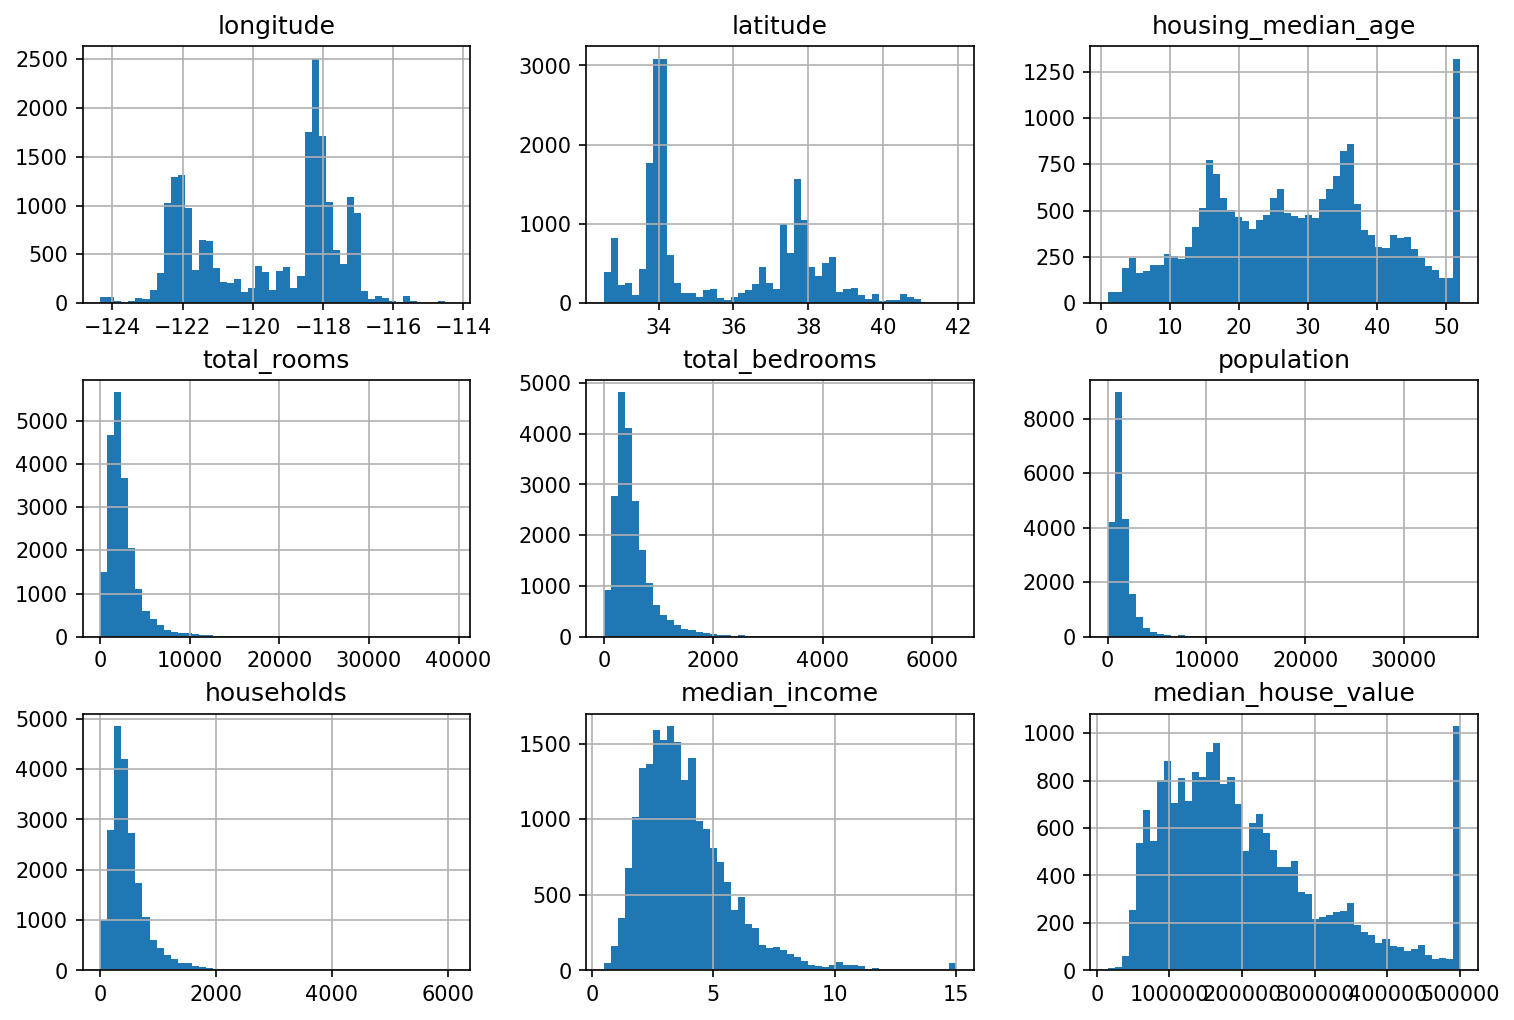

In [7]:
import matplotlib.pyplot as plt
housing_full.hist(bins=50, figsize=(12, 8))

We notice a few things:

- Median income is not expressed in USD. We talk to the
team that collected the data and discover the data has been
capped and scaled. The numbers roughly mean tens of thousands
of dollars.``

- House median value and age have also been capped, which 
might be a problem as median value is our target feature.
We might have to look for labels for these capped values or 
remove them entirely.

- The attributes are at very different scales;

- Many histograms are skewed right, which might need
some data transforming for the ML algorithms to properly
detect patterns

### Create a Test Set

We need to create a test set now, before cleaning 
the data and making decisions about which model to use.
This is because we might end up in the *data snooping bias*
situation. sklearn has a fuction for this, `train_test_split`:

In [8]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing_full, test_size=0.2,
                                       random_state=42)

This would be a purely random sampling method. It is fine if
the data is large enough, but if it is not, we run at the risk
of introducing sampling bias. 

Suppose we talked to experts who told us *median_income* is an
important predictor for our target measure. If we wanted to make
sure that our data has representatives of each income category,
we might want to make an *stratified split*.
We notice most values of median income are between 1.5 and 6.
Thus, we can use `pd.cut()` to make categories for that:

In [9]:
housing_full['income_cat'] = pd.cut(housing_full['median_income'],
                                    bins=[0, 1.5, 3, 4.5, 6, np.inf],
                                    labels=[1, 2, 3, 4, 5])

<Axes: xlabel='income_cat'>

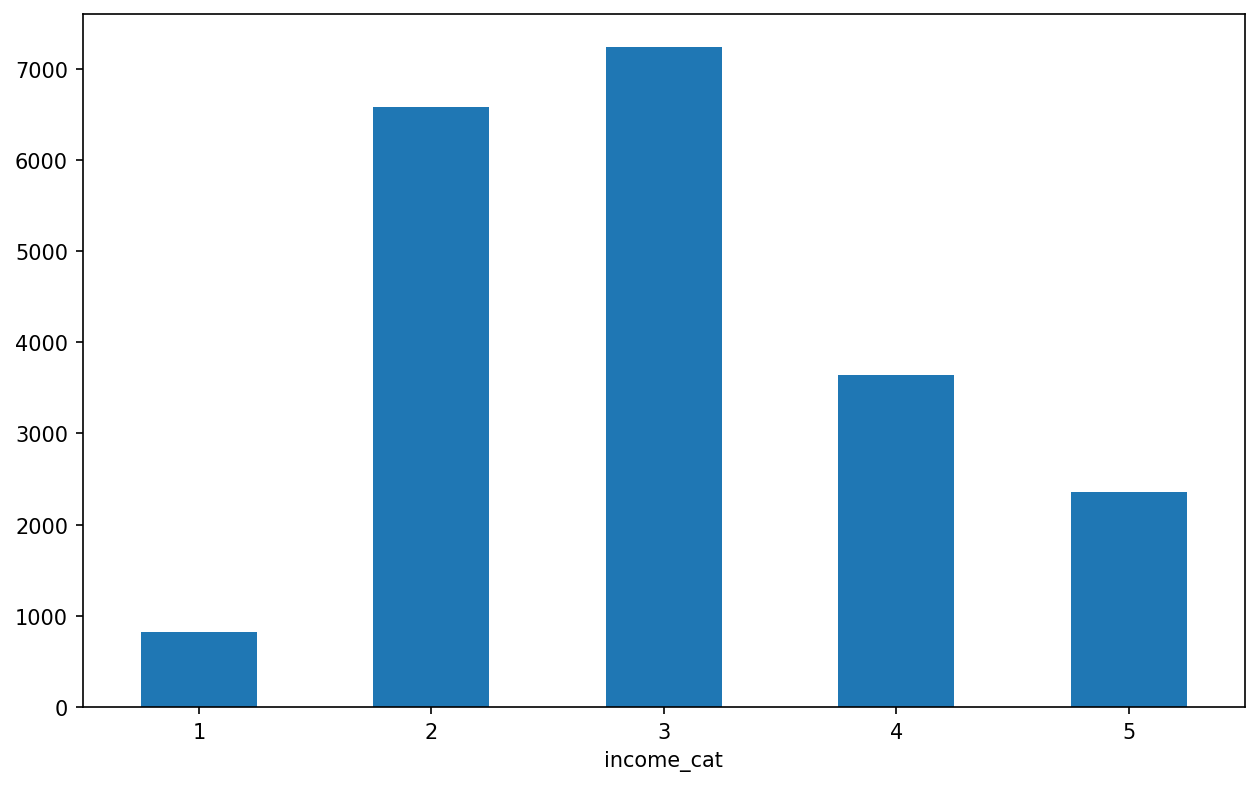

In [10]:
housing_full['income_cat'].value_counts().sort_index().plot.bar(rot=0)

Now we can use sklearn.model_selection's StratifiedShuffleSplit,
which returns a n lists of training and test indices. The n part
is good for later cross-validation. 

More precisely, StratifiedShuffleSplit has a `split()` method that
returns an iterator with the train and test indices.

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit
splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

strat_splits = []
for train_idx, test_idx in splitter.split(housing_full,
                                          housing_full['income_cat']):
  train_set = housing_full.iloc[train_idx]
  test_set = housing_full.iloc[test_idx]
  strat_splits.append([train_set, test_set])

For now, we'll use the first split:

In [12]:
strat_train_set, strat_test_set = strat_splits[0]

There's a shorter way to do this, although it will
require looping for using 10 strats:

In [13]:
"""
strat_train_set, strat_test_set = train_test_split(
  housing_full, test_size=0.2, stratify=housing_full['income_cat'],
  random_state=42
)
""" 

"\nstrat_train_set, strat_test_set = train_test_split(\n  housing_full, test_size=0.2, stratify=housing_full['income_cat'],\n  random_state=42\n)\n"

Lets check if the income categories proportions are 
equal to those in the original dataset:

In [14]:
print(housing_full['income_cat'].value_counts(normalize=True))
print(strat_test_set['income_cat'].value_counts(normalize=True))

income_cat
3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: proportion, dtype: float64
income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: proportion, dtype: float64


Pretty accurate. Now that we won't use `income_cat`
again, we might as well just drop it:

In [15]:
for train_set, test_set in strat_splits:
  train_set = train_set.drop('income_cat', axis=1)
  train_set = test_set.drop('income_cat', axis=1)

In [16]:
strat_train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,458300.0,NEAR BAY,2
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,483800.0,<1H OCEAN,5
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,101700.0,INLAND,2
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,96100.0,INLAND,2
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,361800.0,NEAR OCEAN,3


We took quite some time preparing this test set.
But it is our goal, what we will fit our model to 
excel at. It is a often neglected, but certainly important 
part of the machine learning process. Now, it is time to...

## Explore and Visualize the Data to Gain Insights

We will explore the training set. If it was enormous,
we would make an exploring sample. For now, we will
just make a copy of the training set so that we can
transform it freely:

In [17]:
housing = strat_train_set.copy()

### Visualizing Geografical Data

Since we have Latitude and Logitude values, we can 
plot them in a scatter plot to get a good idea of 
where our data is coming from:

<Axes: xlabel='longitude', ylabel='latitude'>

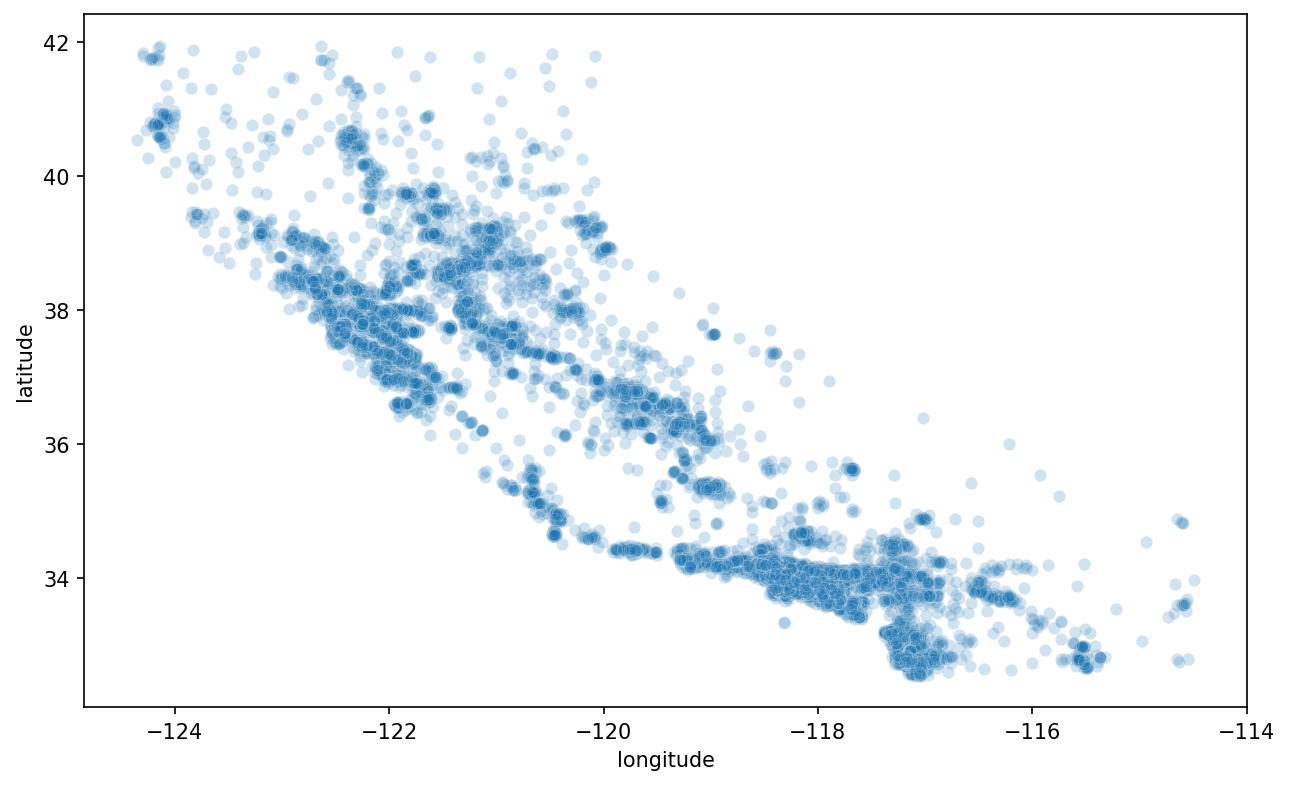

In [18]:
import seaborn as sns
sns.scatterplot(x='longitude', y='latitude', data=housing, alpha=0.2)

<Axes: xlabel='longitude', ylabel='latitude'>

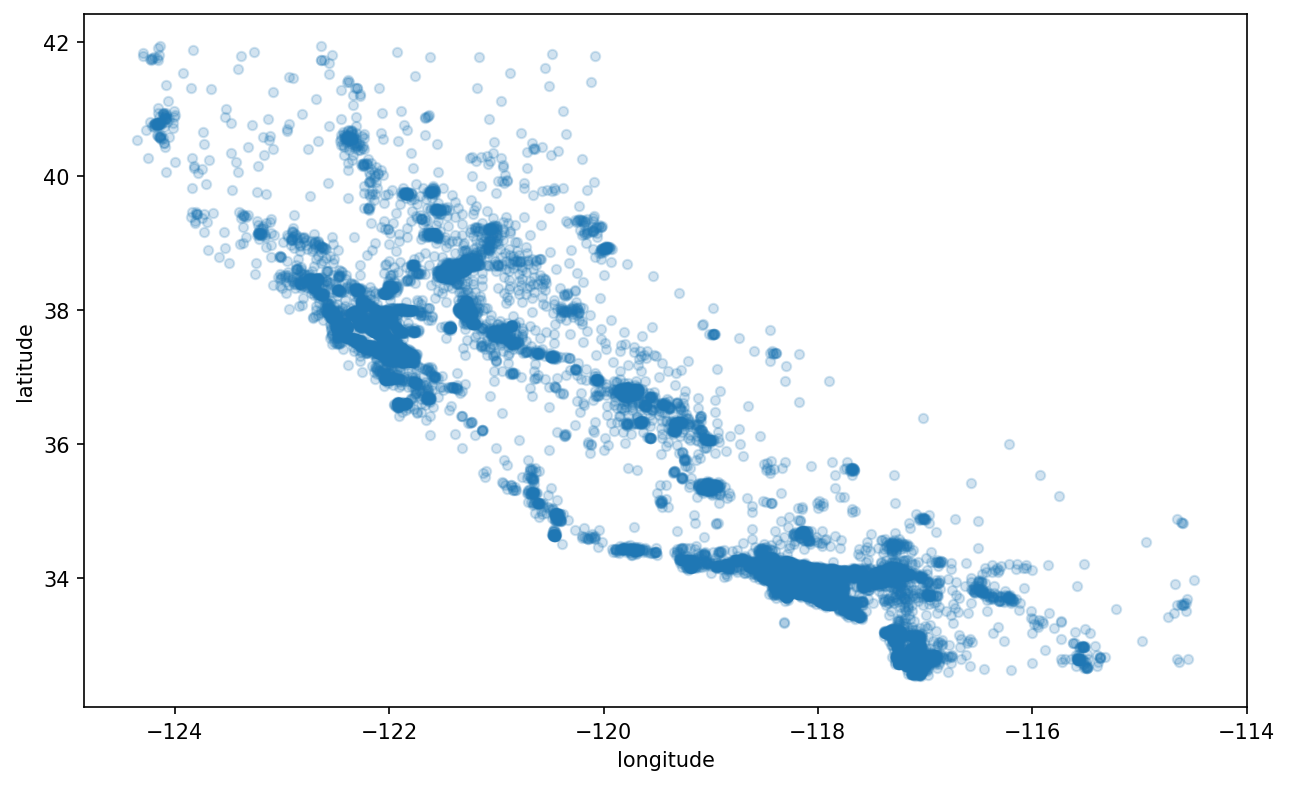

In [19]:
housing.plot.scatter(x='longitude', y='latitude', alpha=0.2)

Two ways of plotting: seaborn and native pandas plot

Now we'll add more elements to the visualization: higher
circle radius for bigger population, and redder colors
for more median house value:

<Axes: xlabel='longitude', ylabel='latitude'>

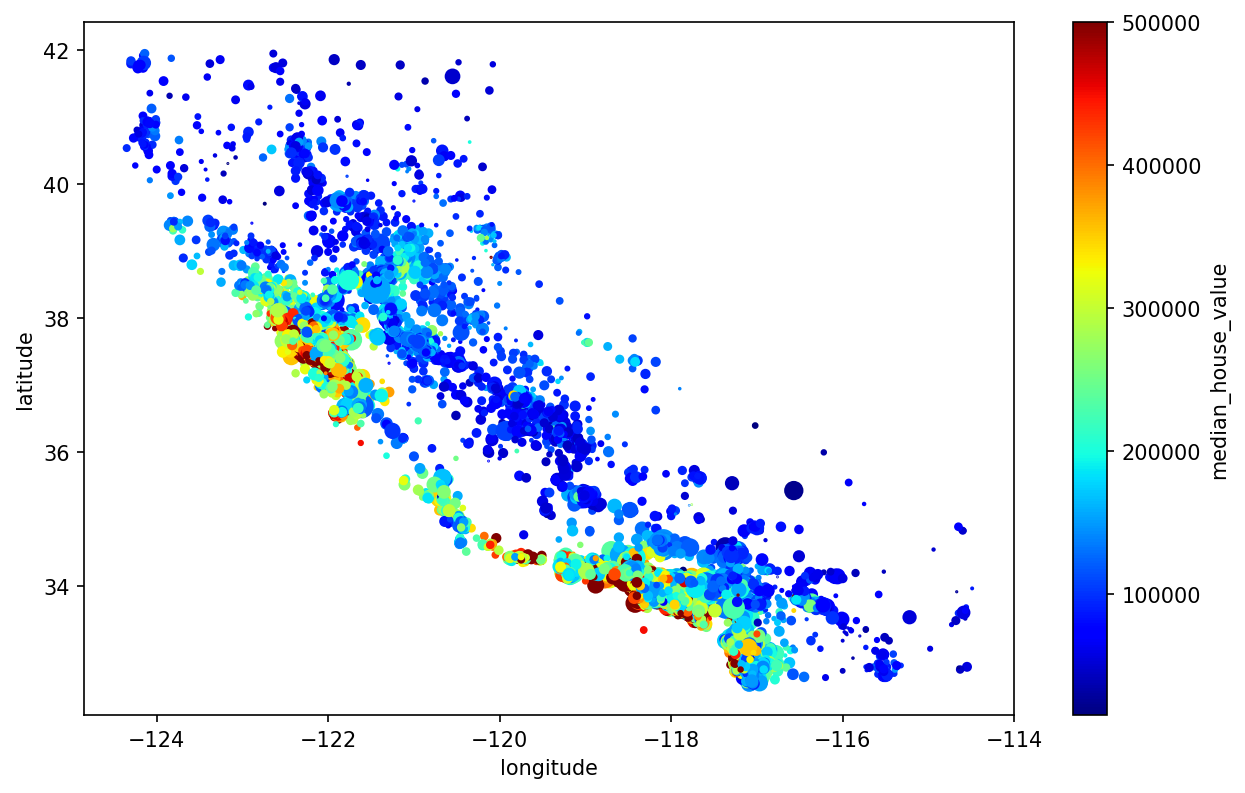

In [20]:
housing.plot.scatter(x='longitude', y='latitude', s=housing['population']/100,
                     c='median_house_value', cmap='jet', legend=True)

Here we can see that in general districts closer
to the ocean are more expensive, although there
seems to be more factors involved.

### Look for correlations

We can compute a correlation matrix with the 
`.corr` method with `numeric_only=True` argument:

In [21]:
corr_matrix = housing.corr(numeric_only=True)

In [22]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

Another way to check for correlations is to compute a
correlation matrix. Since we have 9 numerical attributes,
we'll do this with only the most promising ones:

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

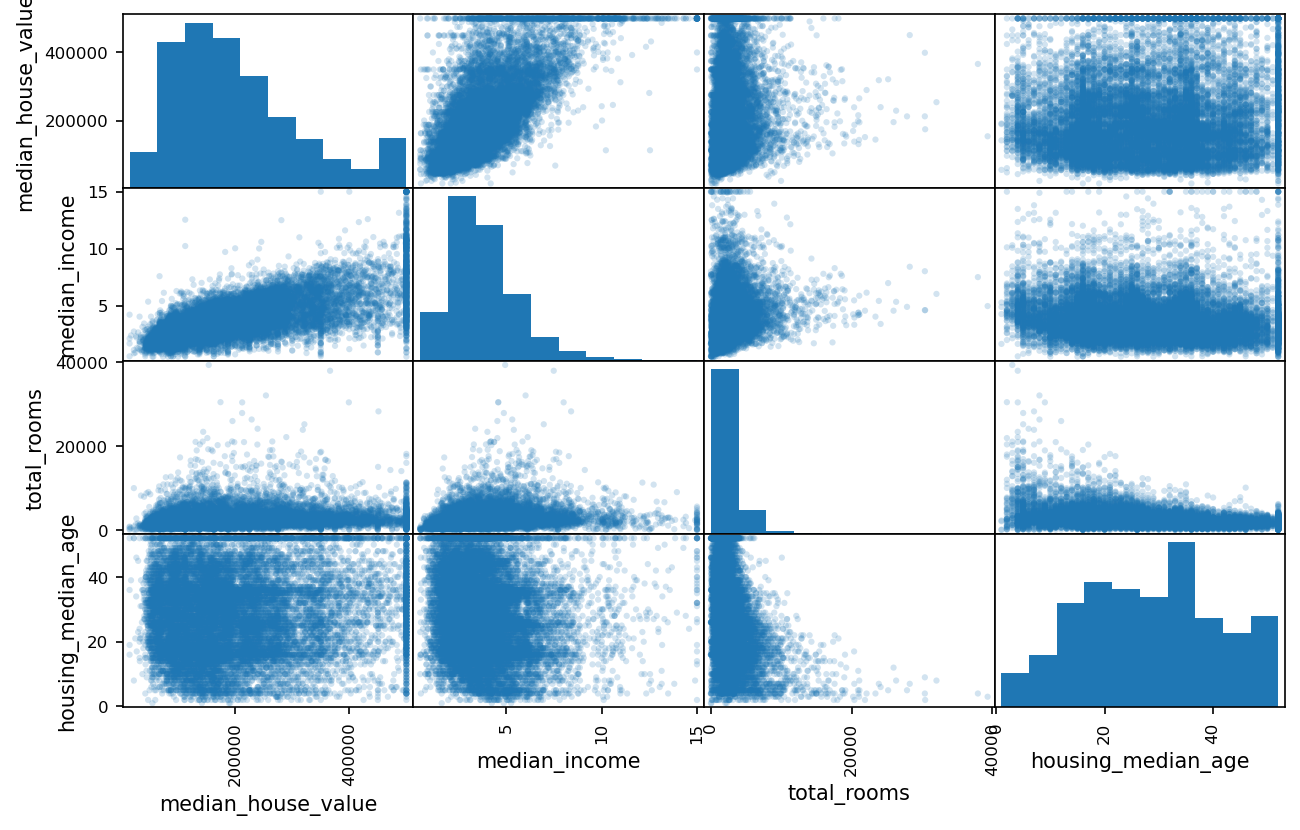

In [23]:
from pandas.plotting import scatter_matrix
atributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[atributes], alpha=0.2)

The most promising one seems indeed to be `median_income`, so 
we'll zoom in on that:

<Axes: xlabel='median_income', ylabel='median_house_value'>

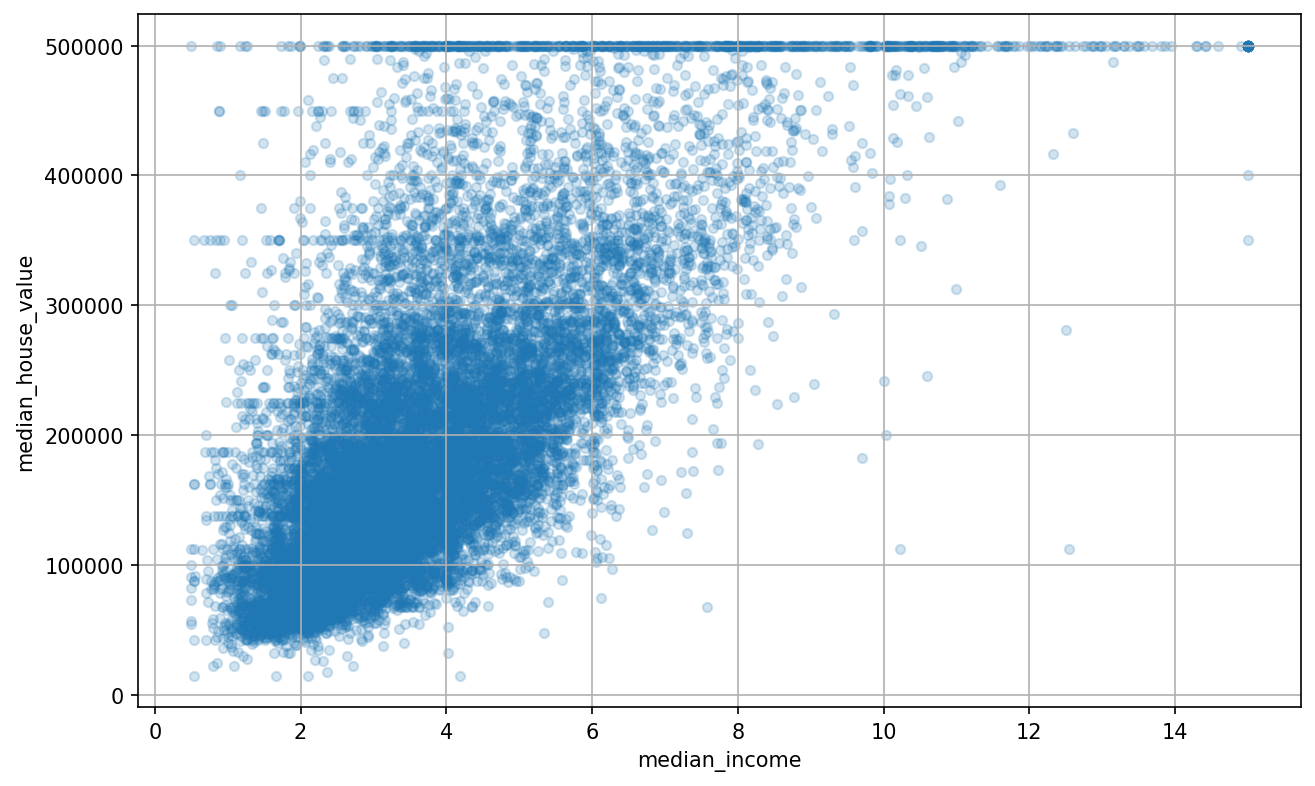

In [24]:
housing.plot.scatter(x='median_income', y='median_house_value', alpha=0.2,
                     grid=True)

Although the data is noisy, we can clearly see an upward
trend. We can also notice a few more subtle problems:
There's a horizontal line around 450000, and also 35000
and maybe 280000. We may consider removing these districts
to avoid our algorithm to learning these data quirks.

### Exploring attribute combinations

Another thing we can do is create attribute combinations
that might be correlated to our target. Consider our
current columns:

In [25]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'income_cat'],
      dtype='str')

Perhaps better than total_rooms in a district, rooms per 
household might make more sense. Also, population per
household could be interesting, as well as a ration between
bedrooms and total rooms. Let's create these columns
and then check their correlation to the target feature:

In [26]:
housing['relative_population'] = housing['population'] / housing['households']
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedroom_ratio'] = housing['total_bedrooms'].div(housing['total_rooms'],
                                                        fill_value=housing['total_bedrooms'].median())

In [27]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value     1.000000
median_income          0.688380
rooms_per_household    0.143663
total_rooms            0.137455
housing_median_age     0.102175
households             0.071426
total_bedrooms         0.054635
population            -0.020153
relative_population   -0.038224
longitude             -0.050859
latitude              -0.139584
bedroom_ratio         -0.229558
Name: median_house_value, dtype: float64

We found that our `rooms_per_household` and `bedroom_ratio`
have stronger correlations than the previous attributes. That
might be nice!

We will halt exploration for now, but we can always come back 
this later. Now, we'll...

## Prepare the Data for Machine Learning Algorithms!

The author recommends creating functions for feature
transformation instead of transforming manually. The
advantages are clear: reproducibility, ease to try
different transformations on the dataset, among others.

First, we'll revert to using the `strat_train_set`,
but without our target label, as we may want to transform
it in a different way than the predicting features.

In [28]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

### Scikit-Learn Design Principles

Scikit-Learn has a simple and consistent API, so building
a mental model of how things work is useful. We have:

#### Estimators

There are objects that estimate some values based on the
data given, such as our `SimpleImputer` with its `fit()`
method and `statistics_` result. All estimators use the
same `fit()` method. Some use two datasets as input: one
for the features, another for the labels. Any extra specification
is considered a hyperparameter and must be set in the estimator 
constructor, such as the `strategy` of the SimpleImputer.

#### Transformers

Some estimator also transform a dataset, such as `SimpleImputer`.
The API is again simple: use the `transform()` method with the 
dataset as input to transform it. These objects also have a 
`fit_transform()` method which is more optimized and does both
steps in a single method.

#### Predictors

Some objects are able to predict data based on features received
from a dataset. These are so called predictors, and an example
is the `LinearRegression` model used previously. A predictor
has a `predict()` method and also a `score()` method for evaluating
the results on a test set (and the corresponding labels, in the
case of supervised learning algorithms).

#### Inspection

All hyperparameters are accessible via instance attributes,
and calculated parameters are accessible with an underscore
suffix (such as `statistics_`)

### Handling Text and Categorical Attributes

Now it's time to handle text in our dataset. We only
have one text column, `ocean_proximity`. Let's look
at it's values:

In [29]:
housing_cat = housing[['ocean_proximity']]
housing_cat['ocean_proximity'].unique()

<ArrowStringArray>
['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND']
Length: 5, dtype: str

There are two ways to encode this: One is with sequential
integers, another with one-hot encoding, which in pandas we
had as `get_dummy()` attribute. Sequential integers can be
obtained with the `OrdinalEncoder` class, from `sklearn.preprocessing`:

In [30]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:8]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.]])

We can check the categories with `categories_` attribute:

In [31]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

The problem here is that ML algorithms tend to consider
closer integers... closer. So we can use dummies with
one-hot encoding instead:

In [32]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder()
housing_cat_encoded = one_hot_encoder.fit_transform(housing_cat)
housing_cat_encoded[:8]

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 8 stored elements and shape (8, 5)>

What is this output? It's a sparse matrix. Sparse matrices
are a more efficient way of storing matrices composed of 
only zeroes and ones. Instead of storing the whole matrix,
they store only the 1 values and their position. We can
convert to a dense numpy array with `.toarray()`, or
use `sparse_output=False` in the construction of the 
`OneHotEncoder()`.

Why use sklearn's encoder instead of pandas? sklearn remembers
the features it was trained on, and if you feed it a category
that wasn't previously informed, it will Raise or ignore,
depending on the set up when constructing the encoder.

### Feature Scaling and Transformation
 
Most ML algorithms perform better when features are
in a same scale. Then, it is a matter of transforming
and inverse transforming any set of features. This can
be done with the labels, too.

#### Min-Max scaling

Scales features down to a certain range, default 0-1:

In [33]:
from sklearn.preprocessing import MinMaxScaler
mmscaler = MinMaxScaler(feature_range=(-1, 1))
housing_num = housing.select_dtypes(np.number)
housin_num_mm_scale = mmscaler.fit_transform(housing_num)
housin_num_mm_scale[:3, :]

array([[-0.60851927,  0.11702128,  1.        , -0.83117147, -0.64116605,
        -0.80701754, -0.61433638, -0.7794789 ],
       [ 0.21095335, -0.66170213,  0.52941176, -0.90014752, -0.88629409,
        -0.91866029, -0.86708979, -0.22929339],
       [-0.51926978,  0.23617021,  0.25490196, -0.94501246, -0.93042358,
        -0.93141946, -0.92458466, -0.73336919]])

#### Standard Scaling

Creates a z-value by subtracting the mean and dividing
by the standard deviation

In [34]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
housing_num_std = std_scaler.fit_transform(housing_num)
housing_num_std[:3]

array([[-1.42303652,  1.0136059 ,  1.86111875,  0.31191221,  1.35909429,
         0.13746004,  1.39481249, -0.93649149],
       [ 0.59639445, -0.702103  ,  0.90762971, -0.30861991, -0.43635598,
        -0.69377062, -0.37348471,  1.17194198],
       [-1.2030985 ,  1.27611874,  0.35142777, -0.71224036, -0.75958421,
        -0.78876841, -0.77572662, -0.75978881]])

#### Bucketizing as numerical

This method can be used (for example, with `pd.qcut`)
for dealing with heavy-tailed features, and then using
the buckets as numerical values.

#### Bucketizing as categories

This strategy is useful for multimodal distributions
(with two or more peaks). We again bucketize, but then
treat the buckets id's as categories, meaning we encode
them again with perhaps `OneHotEncoder`, for example.
This ensures that the ML algorithm can learn different
patterns for different ranges of a value, such as of
`housing_median_age`

#### Radial Basis Function

Another way of dealing with multimodal distributions
is to create a feature for each mode representing the 
similarity between each instance's value and the
mode. This is usually done with a distance function,
such as the Gaussian Radial Basis Function, which
decays exponentially the further from the mode. 
The equation is `e^{-y(x-35)^2}`. It is implemented
in sklearn in `sklearn.metrics.pairwise.rbf_ernel`,
and we'll demonstrate it with the `housing_median_age`, 
which has a one of it's modes around 35:

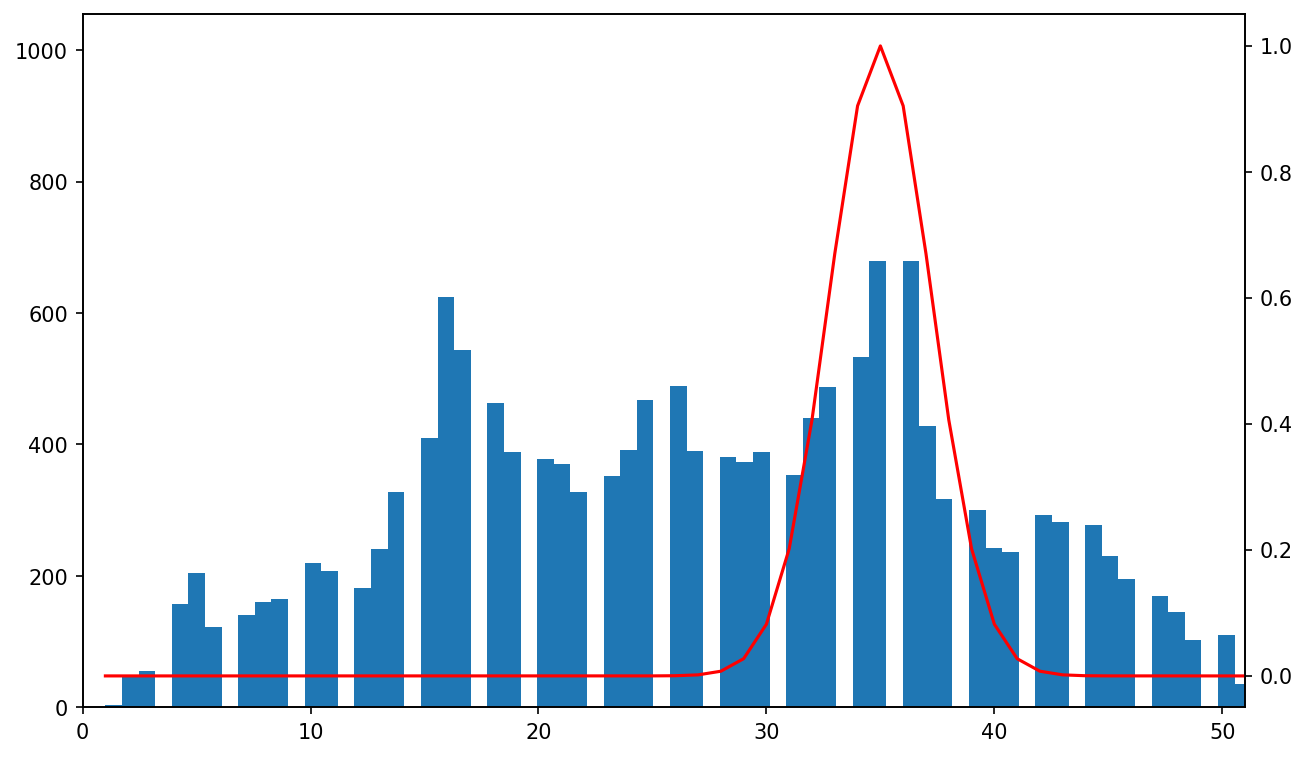

In [35]:
from sklearn.metrics.pairwise import rbf_kernel
import matplotlib.pyplot as plt
age_simil_35 = rbf_kernel(housing[['housing_median_age']].sort_values('housing_median_age'),
                          [[35]], gamma=0.1)
fig, ax = plt.subplots()
ax.hist(x = housing[['housing_median_age']].sort_values('housing_median_age'), bins=70)
ax.set_xlim((0, 51))
ax2 = ax.twinx()
ax2.set_xlim((0, 51))
ax2.plot(housing[['housing_median_age']].sort_values('housing_median_age'), age_simil_35,
         color='red')

#### Transforming the target feature

Transforming the label is also interesting
when it has a heavy tail. But since we want to 
predict the feature itself, not it's transformed
form, we need to reverse the transformation after
the prediction is made. Sklearn implements this 
in the `sklearn.compose` `TransformedTargetRegressor`
class. It has hyperparameters for the model and
`transformer` class instance to use, and returns
the reversed-transformed value with it's `predict`
method:

In [36]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression
model = TransformedTargetRegressor(LinearRegression(),
                                   transformer=StandardScaler())
model.fit(housing[['median_income']], housing_labels)
some_new_data = housing[['median_income']].iloc[:5] # pretend this is new data
predictions = model.predict(some_new_data)

In [37]:
predictions

array([131997.15275877, 299359.35844434, 146023.37185694, 138840.33653057,
       192016.61557639])

### Transformation Pipelines

Transformation pipelines are a way of automating a 
sequence of steps in data transformation, to lastly
make a transformation or another estimator action,
such as a prediction. We make a pipeline with
`sklearn.pipeline`'s `Pipeline` object. In the following
example, we create a numerical attribute pipeline:

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('stardardize', StandardScaler()),
])

The pipeline takes a list of name-estimator tuples. 
The names will be useful for hyperparameter tuning.
If you're lazy, you can use the `make_pipeline`
function instead of the `Pipeline` class, which
will accept transformer classes as positional
arguments, and automatically set names equal to the
classes names in lowercase and no underscores:

In [39]:
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy='median'),
                             StandardScaler())

The pipeline itself has the `fit()`, `transform()`, or
`predict()` methods, depending on if the last estimator
has any of those. When called, the pipeline will `fit_transform()`
every single estimator and pass the result to the next one,
until the last estimator, where it will fit, transform, or predict
according to the appropriate method.

Let's look at the pipeline in action with our `housing_num`
variable:

In [40]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

If we want to construct this as a DataFrame, we can use
the `get_feature_names_out()` method:

In [41]:
df_housing_num_prepared = pd.DataFrame(
    housing_num_prepared, 
    columns=num_pipeline.get_feature_names_out(),
    index=housing_num.index
)
df_housing_num_prepared.iloc[:2].round(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-1.42,1.01,1.86,0.31,1.37,0.14,1.39,-0.94
14973,0.60,-0.70,0.91,-0.31,-0.44,-0.69,-0.37,1.17


We can access each estimator from the pipeline with by indexing
with ints or with the name of the estimator, such as a dictionary
object. 

With `ColumnTransformer` we're able to apply different pipelines
to different columns. We import it from `sklearn.compose`, and
the class takes a list of 3-tuples with the pipeline name,
the pipeline itself, and a list of columns to apply it to:

In [42]:
from sklearn.compose import ColumnTransformer

cat_columns = ['ocean_proximity']
num_columns = ["longitude", "latitude", "housing_median_age",
               "total_rooms",  "total_bedrooms", "population",
               "households", "median_income"]

cat_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

preprocessing = ColumnTransformer([
    ('cat', cat_pipeline, cat_columns),
    ('num', num_pipeline, num_columns)
])

However, we can get lazier than that. Listing all column
names is obviously not that convenient, and perhaps we don't
really care about naming each pipeline step. So instead
of using the class itself, we use `make_column_transformer()` and
`make_column_selector`:

In [43]:
from sklearn.compose import make_column_transformer, make_column_selector

preprocessing = make_column_transformer(
    (cat_pipeline, make_column_selector(dtype_include=object)),
    (num_pipeline, make_column_selector(dtype_include=np.number))
)

Now we can just apply this column transformer to our housing data:

In [44]:
housing_prepared = preprocessing.fit_transform(housing)

### Clusters

Advanced section, but used in the final pipeline:

In [45]:
from sklearn.cluster import KMeans 
from sklearn.base import BaseEstimator, TransformerMixin

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters  
        self.gamma = gamma  
        self.random_state = random_state  

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)  
        self.kmeans_.fit(X, sample_weight=sample_weight)  
        return self # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)  

    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]


### Recap and wrap the pipeline

We've made some decisions about handling the data that
should be recapped before we make the final code that will
transform and prepare all the data:

- NA values in numerical attributes will be replaced by the median.
- NA values in categorical attributes will be replaced by the most frequent
- Categorical attributes will be mapped with One Hot Encoding
- Ratio columns will be added to hopefully better correlate with `median_house_value`: `bedroom_ratio`, `rooms_per_house` and `people_per_house`.
- Clusters and proximity to clusters will be added as they could
be more useful than longitude and latitude;
- Long-tailed features will be replaced with their log;
- All numerical features will be standardized;

The following code will build the pipeline to all of that:

In [46]:
from sklearn.preprocessing import FunctionTransformer

def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ['ratio'] # feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy='median'),
        FunctionTransformer(column_ratio,
                            feature_names_out=ratio_name),
        StandardScaler()
    )

log_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    FunctionTransformer(np.log, feature_names_out='one-to-one'),
    StandardScaler()
)

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1.,
                                  random_state=42)

default_num_pipeline = make_pipeline(
        SimpleImputer(strategy='median'),
        StandardScaler()
)

preprocessing = ColumnTransformer([
    ('bedrooms', ratio_pipeline(), ['total_bedrooms', 'total_rooms']),
    ('rooms_per_house', ratio_pipeline(), ['total_rooms', 'households']),
    ('people_per_house', ratio_pipeline(), ['population', 'households']),
    ('log', log_pipeline, ['total_bedrooms', 'total_rooms', 'population',
                           'households', 'median_income']),
    ('geo', cluster_simil, ['latitude', 'longitude']),
    ('cat', cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline # housing_median_age
)

Running this ColumnTransformer returns a np array with
24 features:

In [47]:
housing.drop('income_cat', axis=1, inplace=True)
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

(16512, 24)

In [48]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

## Select and Train a Model

After we've framed the problem, gathered the data,
explored and visualized it, and set a transformation
pipeline to automatically clean it up and prepare it
for the ML algorithms, it is finally time to select
and train an ML model!

### Train and Evaluate on the Training Set

Thanks to the fact that we did all the previous steps,
this should now be easy! Let's begin by training a simple
linear regression model:

In [49]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)
housing_predictions = lin_reg.predict(housing)

Since we chose root mean squared error as our
performance measure, let's measure it in the 
whole training set: 

In [50]:
from sklearn.metrics import root_mean_squared_error
lin_rmse = root_mean_squared_error(housing_predictions,
                                   housing_labels)
lin_rmse

68972.88910758485

This is quite the error! It is explainable by the model
underfitting the training data. We cannot reduce constraints
in the model as it was not regularized, so perhaps we could
feed it different features or choose a more powerful model.
Let's go with the latter, using a `DecisionTreeRegressor`:

In [51]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)
housing_predictions = tree_reg.predict(housing)
tree_rmse = root_mean_squared_error(housing_predictions,
                                    housing_labels)
tree_rmse

0.0

What's that, a perfect model? Such a thing doesn't exist, 
so the model is probably overfitting the data. To be sure,
we can use cross-validation to better evaluate it:

### Better Evaluation with Cross-Validation

We'll split the training set into 10 pieces. Each 
iteration, we'll train with 9/10 of the pieces and
evaluate with the 1/10 left out. This ensures the new
piece is not part of the learnt data, and thus cannot
have been overfit. `sklearn.model_selection` implements
this with `cross_val_score`:

In [52]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, housing, housing_labels,
                             scoring="neg_root_mean_squared_error",
                             cv=10)

cross_val_score expects an utility function instead of
a cost function, so we use a negative sign and negative
root mean squared error to evaluate. Let's check the
results:

In [53]:
pd.Series(tree_rmses).describe()

count       10.000000
mean     66573.734600
std       1103.402323
min      64607.896046
25%      66204.731788
50%      66388.272499
75%      66826.257468
max      68532.210664
dtype: float64

Our tree is performing almost quite as poorly as the
linear regression model. We'll now try an even more
powerful model, an ensemble model: `RandomForestRegressor`,
imported from `sklearn.ensemble`:

In [54]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing,
                           RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels,
                                scoring='neg_root_mean_squared_error',
                                cv=10)
pd.Series(forest_rmses).describe()

count       10.000000
mean     47038.092799
std       1021.491757
min      45495.976649
25%      46510.418013
50%      47118.719249
75%      47480.519175
max      49140.832210
dtype: float64